# Capping fields from homogeneous to lens at 500V/cm

In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt
import numba
from IPython.display import display, clear_output
%matplotlib inline

In [5]:
def set_fontsize(ax, fs):
    """
    Small function to set font sizes for figures
    """
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    ax.yaxis.offsetText.set_fontsize(fs)
    ax.title.set_size(fs)

In [6]:
from fields import *

def fit_potential_z(x_grid, y_grid, z_grid, pot_grid, r, zmask):
    idx = find_nearest(x_grid, np.sqrt(r**2/2))
    idy = find_nearest(y_grid, np.sqrt(r**2/2))

    maskz = z_grid > zmask
    f = np.abs(pot_grid[idx, idy, :].flatten())[maskz]
    f -= f.min()
    f /= f.max()

    l = maskz.sum()
    z_spliced = np.zeros(l*2)
    ind_sort = np.argsort(-z_grid[maskz])
    z_spliced[:l] = -z_grid[maskz][ind_sort]+zmask
    z_spliced[-l:] = z_grid[maskz]-zmask
    f_spliced = np.zeros(l*2)
    f_spliced[:l] = f[ind_sort]
    f_spliced[-l:] = f
    
    intfun = UnivariateSpline(z_spliced, f_spliced, s = 0)
    return intfun

def fit_potential_xy(x, y, z, potential, r, zmask):
    mask = (np.sqrt(x**2+y**2) > r)
    potential[mask] = np.nan

    maskz = np.abs(z[np.invert(mask)] - zmask) < 1e-4
    c = polyfit2d(x[np.invert(mask)][maskz], y[np.invert(mask)][maskz],
                  potential[np.invert(mask)][maskz], [3,3])

    return c

def fit_potential_xyz(fname, rxy, rz, zmaskxy, zmaskz, scale = 1):
    x,y,z,potential = load_potential(fname)
    potential *= scale
    (x_grid, y_grid, z_grid), pot_grid = create_grid_potential(x,y,z,potential)
    intfun = fit_potential_z(x_grid,y_grid,z_grid,pot_grid,rz,zmaskz)
    c = fit_potential_xy(x,y,z,potential, rxy, zmaskxy)

    return c, intfun

In [7]:
field_dir = ''
c, intfun = fit_potential_xyz(field_dir+'potentialQuadrupole.fld', 0.022, 0.019, 0, 0.23)
cP, intfunP = fit_potential_xyz(field_dir+'potentialElectrodes.fld', 0.022, 0.019, .45, 0.23)
funEx,funEy,funEz,funEmag = combine_quadrupole_plate(c,intfun,cP,intfunP)

C:\Users\Olivier\Documents\Drive\CeNTREX Olivier\notebooks\non-adiabatic transitions\propagation\fields.py:46: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c = np.linalg.lstsq(vander, f)[0]


In [8]:
def funEvec(funEx, funEy, funEz, x,y,z, Emax):
    size = 0
    c = (x,y,z)
    for val in c:
        if isinstance(val, (np.ndarray, list, tuple)):
            size = len(val)
    if size > 0:
        E = np.zeros([size, 3])
        E[:,0] = funEx(*c)
        E[:,1] = funEy(*c)
        E[:,2] = funEz(*c)
    else:
        E = np.zeros([3])
        E[0] = funEx(*c)
        E[1] = funEy(*c)
        E[2] = funEz(*c)
    E[E > Emax] = Emax
    E[E < -Emax] = -Emax
    return E

In [9]:
E = funEvec(funEx, funEy, funEz, 0.001, 0.001, np.linspace(-0.27, 0.27, 1001), 400)

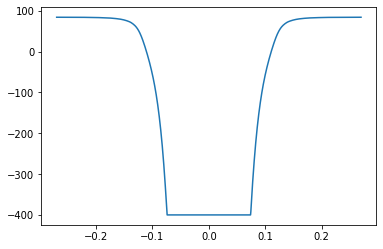

In [10]:
E = funEvec(funEx, funEy, funEz, 0.001, 0.001, np.linspace(-0.27, 0.27, 1001), 400)
plt.plot(np.linspace(-0.27, 0.27, 1001), E[:,1])

In [11]:
from hamiltonianoperators import Hamiltonian

In [12]:
%%time
hamJ6 = Hamiltonian(6,0.5,0.5)
hamJ5 = Hamiltonian(5,0.5,0.5)
hamJ4 = Hamiltonian(4,0.5,0.5)
hamJ3 = Hamiltonian(3,0.5,0.5)

Wall time: 1min 44s


In [24]:
def generate_coords(traj, dt):
    t = np.arange(0, (traj[-2]-traj[-3])/traj[-1], dt)
    coords = np.empty([len(t), 3])
    coords[:,0] = traj[0]
    coords[:,1] = traj[1]
    coords[:,2] = traj[-3]+traj[-1]*t
    return coords

In [11]:
from scipy.linalg import expm
from tqdm import tqdm_notebook as tqdm

def propagate_expm_tqdm(ham, funEvec, B, t, traj, initState):
    x,y,zI,zF,v = traj
    cI = (x,y,zI)
    eigvals, eigvecs = np.linalg.eigh(ham.create_hamiltonian(*funEvec(*cI), *B))
    
    phi0 = eigvecs[:,initState]
    phi = phi0.copy()
    dt = np.diff(t)[0]
    z = zI
    for ti in tqdm(t):
        phi = (expm(-1j*ham.create_hamiltonian(*funEvec(x,y,z), *B)*dt)@phi)
        z = zI + ti*v

    return phi0, phi

def propagate_expm(ham, funEvec, B, t, traj, initState):
    x,y,zI,zF,v = traj
    cI = (x,y,zI)
    eigvals, eigvecs = np.linalg.eigh(ham.create_hamiltonian(*funEvec(*cI), *B))
    
    phi0 = eigvecs[:,initState]
    phi = phi0.copy()
    dt = np.diff(t)[0]
    z = zI
    for ti in t:
        phi = (expm(-1j*ham.create_hamiltonian(*funEvec(x,y,z), *B)*dt)@phi)
        z = zI + ti*v

    return phi0, phi

In [203]:
probabilities = []
for ham in tqdm([hamJ3, hamJ4, hamJ5, hamJ6]):
    traj = (0.006, 0.001, -0.27, 0.27, 200)
    B = (0, 0.5, 0)
    dt = 5e-7
    t = np.arange(0, (traj[-2]-traj[-3])/traj[-1], dt)
    Ev = lambda x,y,z: funEvec(funEx, funEy, funEz, x,y,z, 500)
    phi, phi0 = propagate_expm_tqdm(ham, Ev, B, t, traj, 35)
    probabilities.append(np.abs(phi.conj()@phi0))

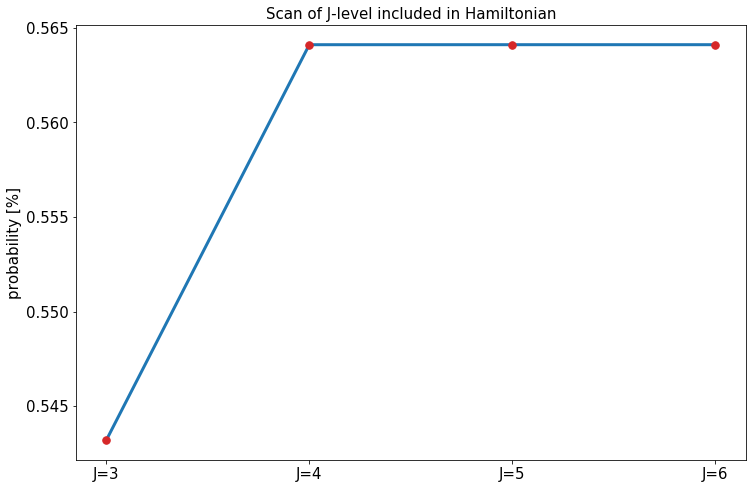

In [221]:
labels = 'J=3, J=4, J=5, J=6'.split(',')
labels = [l.strip() for l in labels]

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(probabilities, lw = 3)
ax.plot(probabilities, '.C3', ms = 15)
ax.set_xticks([0,1,2,3])
ax.set_ylabel('probability [%]')
ax.set_title('Scan of J-level included in Hamiltonian')
ax.set_xticklabels(labels);
set_fontsize(ax, 15)

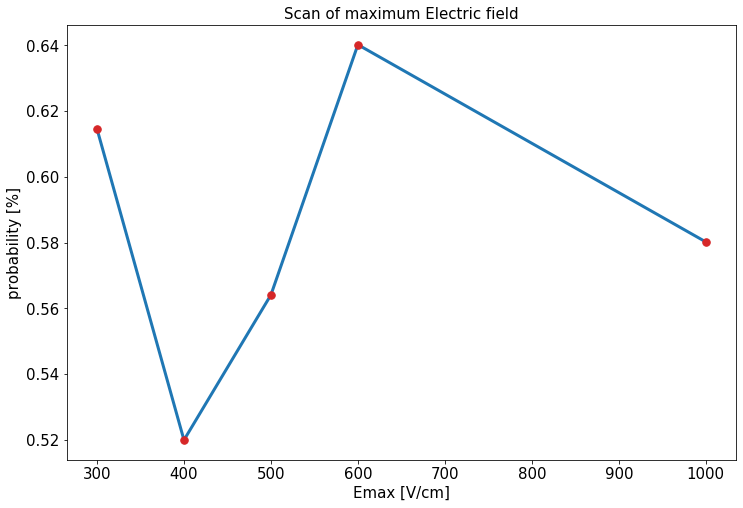

In [17]:
fig, ax = plt.subplots(figsize = (12,8))
ax.set_xlabel('Emax [V/cm]')
ax.set_ylabel('probability [%]')
ax.set_title('Scan of maximum Electric field')
set_fontsize(ax, 15)

probabilities = []
Emaxs = [300,400,500,600,1000]

for Emax in Emaxs:
    traj = (0.006, 0.001, -0.27, 0.27, 200)
    B = (0, 0.5, 0)
    dt = 5e-7
    t = np.arange(0, (traj[-2]-traj[-3])/traj[-1], dt)
    Ev = lambda x,y,z: funEvec(funEx, funEy, funEz, x,y,z, Emax)
    phi, phi0 = propagate_expm(hamJ6, Ev, B, t, traj, 35)
    probabilities.append(np.abs(phi.conj()@phi0))
    
    ax.cla()
    ax.plot(Emaxs[:len(probabilities)], probabilities, lw = 3)
    ax.plot(Emaxs[:len(probabilities)], probabilities, '.C3', ms = 15)
    ax.set_xlabel('Emax [V/cm]')
    ax.set_ylabel('probability [%]')
    ax.set_title('Scan of maximum Electric field')
    set_fontsize(ax, 15)
    display(fig)
    clear_output(wait = True)

In [18]:
import adaptive
import holoviews as hv
adaptive.notebook_extension()

In [73]:
def propagate_xy(xy):
    x,y = xy
    traj = (x, y, -0.27, 0.27, 200)
    B = (0, 0.5, 0)
    dt = 5e-7
    t = np.arange(0, (traj[-2]-traj[-3])/traj[-1], dt)
    Ev = lambda x,y,z: funEvec(funEx, funEy, funEz, x,y,z, Emax=500)
    phi, phi0 = propagate_expm(hamJ4, Ev, B, t, traj, 35)
    return np.abs(phi.conj()@phi0)**2

In [74]:
learner = adaptive.Learner2D(propagate_xy, bounds=[(-0.008,0.008), (-0.015, 0.015)])

In [75]:
runner = adaptive.Runner(learner, goal=lambda l: l.loss() < 0.01)
runner.live_info()

In [78]:
def plot(learner):
    plot = learner.plot(tri_alpha=0.2)
    return plot.Image + plot.EdgePaths.I + plot

runner.live_plot(plotter=plot, update_interval=5)

Button(description='cancel live-plot', layout=Layout(width='150px'), style=ButtonStyle())

:DynamicMap   []
   :Layout
      .Overlay.I   :Overlay
         .I :Image   [x,y]   (z)
      .EdgePaths.I :EdgePaths   [x,y]
      .Overlay.II  :Overlay
         .Image.I     :Image   [x,y]   (z)
         .EdgePaths.I :EdgePaths   [x,y]

In [93]:
traj = (-0.008, 0.001, -0.27, 0.27, 200)
B = (0, 0.5, 0)
dt = 5e-7
t = np.arange(0, (traj[-2]-traj[-3])/traj[-1], dt)
Ev = lambda x,y,z: funEvec(funEx, funEy, funEz, x,y,z, Emax=500)
phi, phi0 = propagate_expm_tqdm(hamJ4, Ev, B, t, traj, 35)
np.abs(phi.conj()@phi0)**2

0.07191055217222268

In [94]:
traj = (-0.008, 0.001, -0.27, 0.27, 200)
B = (0, 0.5, 0)
dt = 5e-7
t = np.arange(0, (traj[-2]-traj[-3])/traj[-1], dt)
Ev = lambda x,y,z: funEvec(funEx, funEy, funEz, x,y,z, Emax=500)
phi, phi0 = propagate_expm_tqdm(hamJ6, Ev, B, t, traj, 35)
np.abs(phi.conj()@phi0)**2

0.07191079135257665

In [102]:
def funEvec_not_masked(funEx, funEy, funEz,x,y,z):
    size = 0
    c = (x,y,z)
    for val in c:
        if isinstance(val, (np.ndarray, list, tuple)):
            size = len(val)
    if size > 0:
        E = np.zeros([size, 3])
        E[:,0] = funEx(*c)
        E[:,1] = funEy(*c)
        E[:,2] = funEz(*c)
    else:
        E = np.zeros([3])
        E[0] = funEx(*c)
        E[1] = funEy(*c)
        E[2] = funEz(*c)
    return E
        
c, intfun = fit_potential_xyz(field_dir+'potentialQuadrupole.fld', 0.022, 0.019, 0, 0)
cP, intfunP = fit_potential_xyz(field_dir+'potentialElectrodes.fld', 0.022, 0.019, .45, 0)
funEx,funEy,funEz,funEmag = combine_quadrupole_plate(c,intfun,cP,intfunP)

traj = (-0.008, 0.001, -0.45, 0.45, 200)
B = (0, 0.5, 0)
dt = 5e-7
t = np.arange(0, (traj[-2]-traj[-3])/traj[-1], dt)
Ev = lambda x,y,z: funEvec_not_masked(funEx, funEy, funEz, x,y,z)
phi, phi0 = propagate_expm_tqdm(hamJ6, Ev, B, t, traj, 35)
np.abs(phi.conj()@phi0)**2

0.8278315870704258

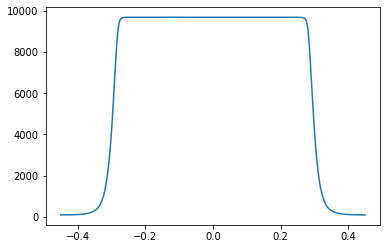

In [101]:
E = funEvec(funEx, funEy, funEz, -0.008, 0.001, np.linspace(-0.45, 0.45, 1001), 30000)
plt.plot(np.linspace(-0.45, 0.45, 1001), E[:,1])

In [103]:
c, intfun = fit_potential_xyz(field_dir+'potentialQuadrupole.fld', 0.022, 0.019, 0, 0.1)
cP, intfunP = fit_potential_xyz(field_dir+'potentialElectrodes.fld', 0.022, 0.019, .45, 0.1)
funEx,funEy,funEz,funEmag = combine_quadrupole_plate(c,intfun,cP,intfunP)

traj = (-0.008, 0.001, -0.35, 0.35, 200)
B = (0, 0.5, 0)
dt = 5e-7
t = np.arange(0, (traj[-2]-traj[-3])/traj[-1], dt)
Ev = lambda x,y,z: funEvec_not_masked(funEx, funEy, funEz, x,y,z)
phi, phi0 = propagate_expm_tqdm(hamJ6, Ev, B, t, traj, 35)
np.abs(phi.conj()@phi0)

0.8993161460004542

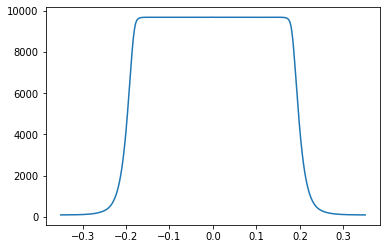

In [104]:
E = funEvec(funEx, funEy, funEz, -0.008, 0.001, np.linspace(-0.35, 0.35, 1001), 30000)
plt.plot(np.linspace(-0.35, 0.35, 1001), E[:,1])

probability = 0.9507


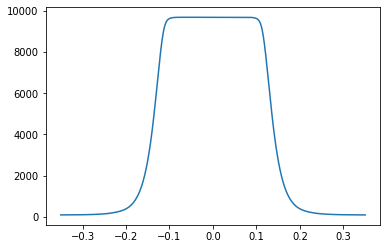

In [106]:
c, intfun = fit_potential_xyz(field_dir+'potentialQuadrupole.fld', 0.022, 0.019, 0, 0.2)
cP, intfunP = fit_potential_xyz(field_dir+'potentialElectrodes.fld', 0.022, 0.019, .45, 0.2)
funEx,funEy,funEz,funEmag = combine_quadrupole_plate(c,intfun,cP,intfunP)

traj = (-0.008, 0.001, -0.25, 0.25, 200)
B = (0, 0.5, 0)
dt = 5e-7
t = np.arange(0, (traj[-2]-traj[-3])/traj[-1], dt)
Ev = lambda x,y,z: funEvec_not_masked(funEx, funEy, funEz, x,y,z)
phi, phi0 = propagate_expm_tqdm(hamJ6, Ev, B, t, traj, 35)
print(f'probability = {np.abs(phi.conj()@phi0):.4f}')

E = funEvec(funEx, funEy, funEz, -0.008, 0.001, np.linspace(-0.25, 0.25, 1001), 30000)
plt.plot(np.linspace(-0.35, 0.35, 1001), E[:,1])

# Checking state evolution for a field going from Emax to 0 back to Emax

In [306]:
from scipy import signal

def propagate_Vfield_tqdm(ham, Emax, dEdt, B, steps, initState):
    t = np.linspace(-1,1,steps)
    E = (signal.sawtooth(t*np.pi, width = 0.5)+1)/2 * Emax
    t = (t+1) * Emax/dEdt
    
    H0 = ham.create_hamiltonian(0,0,E[0], *B)
    eigvals, eigvecs = np.linalg.eigh(H0)
    
    phi0 = eigvecs[:,initState]
    phii = phi0.copy()
    dt = np.diff(t)[0]
    H = np.empty([len(t),*H0.shape], dtype = 'complex')
    phi = np.empty([len(t), *phi0.shape], dtype = 'complex')
    
    dt = np.diff(t)[0]
    for idx, Ei in enumerate(tqdm(E)):
        Hi = ham.create_hamiltonian(0,0,Ei, *B)
        phii = (expm(-1j*Hi*dt)@phii)
        H[idx,:] = Hi
        phi[idx,:] = phii

    return t, E, phi, H

In [307]:
def propagate_Vfield(ham, Emax, dEdt, B, steps, initState):
    t = np.linspace(-1,1,steps)
    E = (signal.sawtooth(t*np.pi, width = 0.5)+1)/2 * Emax
    t = (t+1) * Emax/dEdt
    
    H0 = ham.create_hamiltonian(0,0,E[0], *B)
    eigvals, eigvecs = np.linalg.eigh(H0)
    
    phi0 = eigvecs[:,initState]
    phii = phi0.copy()
    dt = np.diff(t)[0]
    H = np.empty([len(t),*H0.shape], dtype = 'complex')
    phi = np.empty([len(t), *phi0.shape], dtype = 'complex')
    
    dt = np.diff(t)[0]
    for idx, Ei in enumerate(E):
        Hi = ham.create_hamiltonian(0,0,Ei, *B)
        phii = (expm(-1j*Hi*dt)@phii)
        H[idx,:] = Hi
        phi[idx,:] = phii

    return t, E, phi, H

## Field change velocity scan
Checking the final state probability as a function of the rate of change of the electric field.  
First simulation for Emax = 200 V/cm

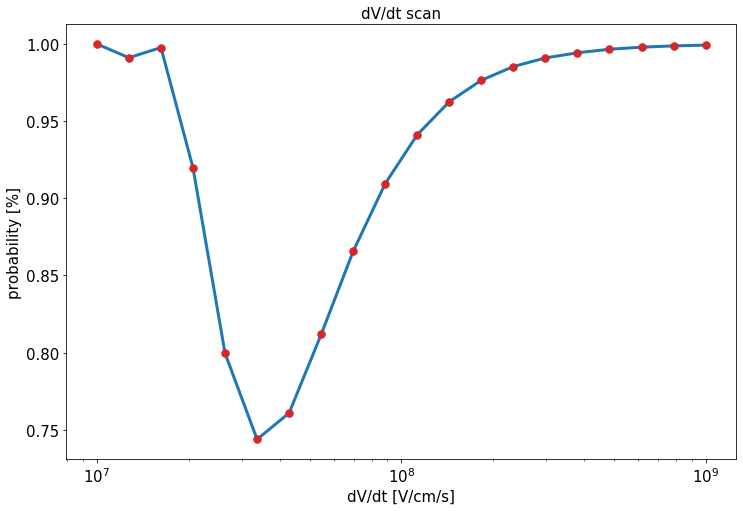

In [603]:
fig, ax = plt.subplots(figsize = (12,8))
ax.set_xlabel('dV/dt [V/cm/s]')
ax.set_ylabel('probability [%]')
ax.set_title('dV/dt scan')
set_fontsize(ax, 15)

probabilities = []
dVdt = np.logspace(7,9,20)

for dV in dVdt:
    t,E,phi,H = propagate_Vfield(hamJ6, 200, dV, (0,0,0.5), 500, 35)
    probabilities.append(np.abs(phi[-1].conj()@phi[0])**2)
    
    ax.cla()
    ax.plot(dVdt[:len(probabilities)], probabilities, lw = 3)
    ax.plot(dVdt[:len(probabilities)], probabilities, '.C3', ms = 15)
    ax.set_xlabel('dV/dt [V/cm/s]')
    ax.set_ylabel('probability [%]')
    ax.set_title('dV/dt scan')
    ax.set_xscale('log')
    set_fontsize(ax, 15)
    display(fig)
    clear_output(wait = True)

## Running the worst rate of change again, storing all parameters in memory for analysis

In [604]:
t,E,phi,H = propagate_Vfield_tqdm(hamJ6, 200, 33598182, (0,0,0.5), 500, 35)
energies, populations = calculate_levels_populations(phi, H)

In [605]:
%%time
from order_eigenstates import *
energiesSorted, eigenvectors, order = eigenshuffle(H, return_reorder = True)

Wall time: 1min 44s


Ordered the eigenstates and eigenvectors to make it easier to track the state evolution 

In [607]:
def calculate_levels_populations_sorted(phi, phiSorted):
    populations = np.empty(phi.shape)
    for idx, (phiI, phiS) in enumerate(tqdm(zip(phi, phiSorted), total = len(phi))):
        for idy, p in enumerate(phiS.T):
            populations[idx,idy] = np.abs(p.conj()@phiI)**2
    return populations

In [608]:
populationsSorted = calculate_levels_populations_sorted(phi, eigenvectors)

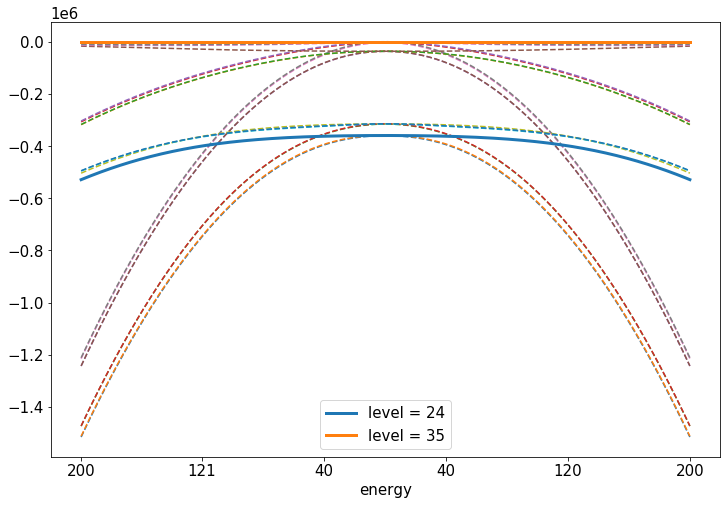

In [613]:
idxmax = len(E)
colors = ['C0', 'C1', 'C3', 'C4', 'C5']
idc = 0
fig, ax = plt.subplots(figsize = (12,8))
for idx in range(16,36):
    if idx in np.unique(np.where(populationsSorted > 0.05)[-1]):
        ax.plot(energiesSorted[:idxmax,idx]-energiesSorted[:idxmax,35], colors[idc], label = f'level = {idx}', lw = 3)
        idc += 1
    else:
        ax.plot(energiesSorted[:idxmax,idx]-energiesSorted[:idxmax,35], '--')
pos = np.linspace(0,len(E)-1,6, dtype = int)
ax.set_xticks(pos)
ax.set_xticklabels([f'{Ei:.0f}'for Ei in E[pos]]);
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.legend(fontsize = 15)
ax.set_xlabel('E [V/cm]')
ax.set_ylabel('energy')
set_fontsize(ax, 15)

They end up going from m$_J=0$ to another m$_J$ state, with about 75% remaining in the desired state

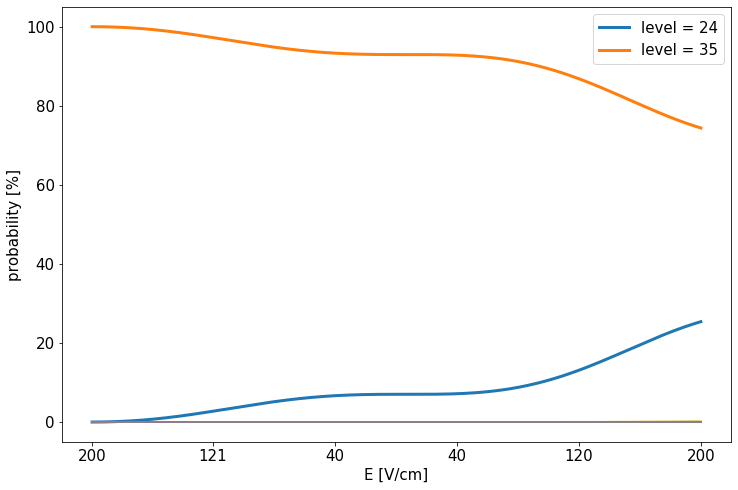

In [612]:
colors = ['C0', 'C1', 'C3', 'C4', 'C5']
idc = 0

fig, ax = plt.subplots(figsize = (12,8))
for idx in range(16,36):
    if idx in np.unique(np.where(populationsSorted > 0.05)[-1]):
        ax.plot(populationsSorted[:idxmax,idx]*100, colors[idc], label = f'level = {idx}', lw = 3)
        idc += 1
    else:
        ax.plot(populationsSorted[:idxmax,idx]*100, '-')

pos = np.linspace(0,len(E)-1,6, dtype = int)
ax.set_xticks(pos)
ax.set_xticklabels([f'{Ei:.0f}'for Ei in E[pos]]);
ax.legend(fontsize = 15)
ax.set_xlabel('E [V/cm]')
ax.set_ylabel('probability [%]')
set_fontsize(ax, 15)

In [611]:
hamJ6.level_eigenstates(0,0,200,0,0,0.5, [24], 0.5)
hamJ6.level_eigenstates(0,0,200,0,0,0.5, [35], 0.5)

-----------------------
Level = 24
E = +4.0139701428464785e+07 kHz
	-1.000 +0.000i 2 -1 +0.5 +0.5
	-0.884 +0.000i 2 +1 -0.5 -0.5
-----------------------
Level = 35
E = +4.0140229601380810e+07 kHz
	-1.000 +0.000i 2 +0 +0.5 -0.5
	-0.936 +0.000i 2 +0 -0.5 +0.5


The state they end up going to is a superposition of m$J=1$ and m$_J=-1$

## Field change velocity scan
Checking the final state probability as a function of the rate of change of the electric field.  
First simulation for Emax = 400 V/cm

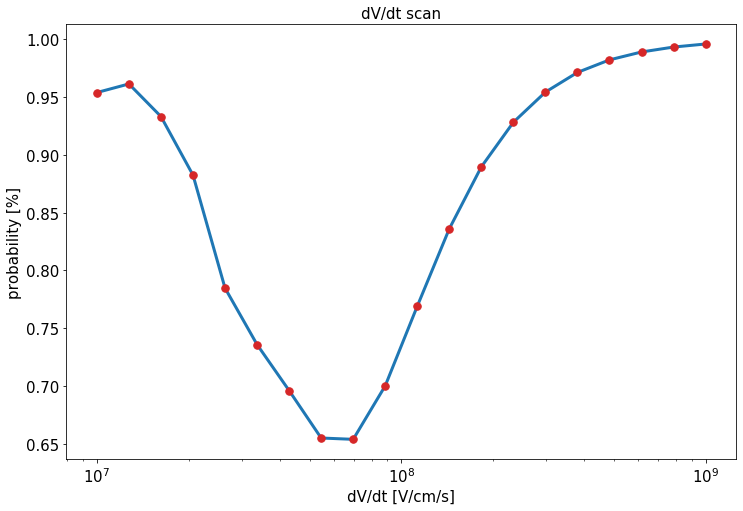

In [614]:
fig, ax = plt.subplots(figsize = (12,8))
ax.set_xlabel('dV/dt [V/cm/s]')
ax.set_ylabel('probability [%]')
ax.set_title('dV/dt scan')
set_fontsize(ax, 15)

probabilities = []
dVdt = np.logspace(7,9,20)

for dV in dVdt:
    t,E,phi,H = propagate_Vfield(hamJ6, 400, dV, (0,0,0.5), 1000, 35)
    probabilities.append(np.abs(phi[-1].conj()@phi[0])**2)
    
    ax.cla()
    ax.plot(dVdt[:len(probabilities)], probabilities, lw = 3)
    ax.plot(dVdt[:len(probabilities)], probabilities, '.C3', ms = 15)
    ax.set_xlabel('dV/dt [V/cm/s]')
    ax.set_ylabel('probability [%]')
    ax.set_title('dV/dt scan')
    ax.set_xscale('log')
    set_fontsize(ax, 15)
    display(fig)
    clear_output(wait = True)

In [615]:
t,E,phi,H = propagate_Vfield_tqdm(hamJ6, 400, 5e7, (0,0,0.5), 2000, 35)
energies, populations = calculate_levels_populations(phi, H)

In [616]:
%%time
from order_eigenstates import *
energiesSorted, eigenvectors, order = eigenshuffle(H, return_reorder = True)

Wall time: 8min 11s


In [617]:
populationsSorted = calculate_levels_populations_sorted(phi, eigenvectors)

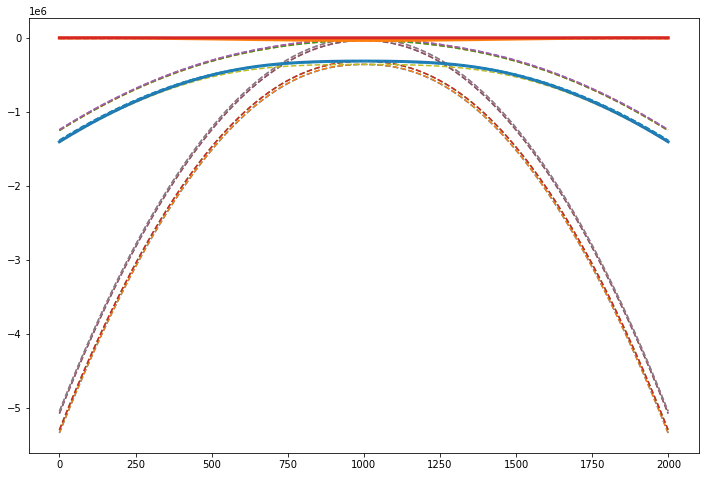

In [618]:
idxmax = 2000
colors = ['C0', 'C1', 'C3', 'C4', 'C5']
idc = 0
fig, ax = plt.subplots(figsize = (12,8))
for idx in range(16,36):
    if idx in np.unique(np.where(populationsSorted > 0.05)[-1]):
        ax.plot(energiesSorted[:idxmax,idx]-energiesSorted[:idxmax,35], colors[idc], lw = 3)
        idc += 1
    else:
        ax.plot(energiesSorted[:idxmax,idx]-energiesSorted[:idxmax,35], '--')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

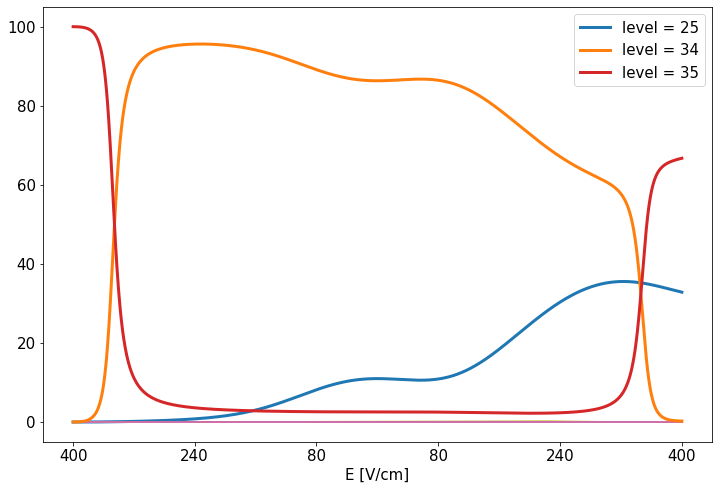

In [619]:
colors = ['C0', 'C1', 'C3', 'C4', 'C5']
idc = 0

fig, ax = plt.subplots(figsize = (12,8))
for idx in range(16,36):
    if idx in np.unique(np.where(populationsSorted > 0.05)[-1]):
        ax.plot(populationsSorted[:idxmax,idx]*100, colors[idc], label = f'level = {idx}', lw = 3)
        idc += 1
    else:
        ax.plot(populationsSorted[:idxmax,idx]*100, '-')

pos = np.linspace(0,len(E)-1,6, dtype = int)
ax.set_xticks(pos)
ax.set_xticklabels([f'{Ei:.0f}'for Ei in E[pos]]);
ax.legend(fontsize = 15)
ax.set_xlabel('E [V/cm]')
set_fontsize(ax, 15)

In [620]:
hamJ6.level_eigenstates(0,0,400,0,0,0.5, np.unique(np.where(populationsSorted > 0.05)[-1]), 0.5)

-----------------------
Level = 25
E = +4.0140720096018754e+07 kHz
	-1.000 +0.000i 2 +1 -0.5 -0.5
	+0.630 +0.000i 2 -1 +0.5 +0.5
-----------------------
Level = 34
E = +4.0142120222957142e+07 kHz
	+1.000 +0.000i 2 +0 -0.5 +0.5
	+0.743 +0.000i 2 +0 +0.5 -0.5
-----------------------
Level = 35
E = +4.0142122976632006e+07 kHz
	+1.000 +0.000i 2 +0 +0.5 -0.5
	-0.745 +0.000i 2 +0 -0.5 +0.5


The state they end up going to is a superposition of m$J=1$ and m$_J=-1$, but now in the intermediate state they end up going through an avoided crossing around 380 V/cm to another m$_J=0$ state, from which they return when crossing through again.

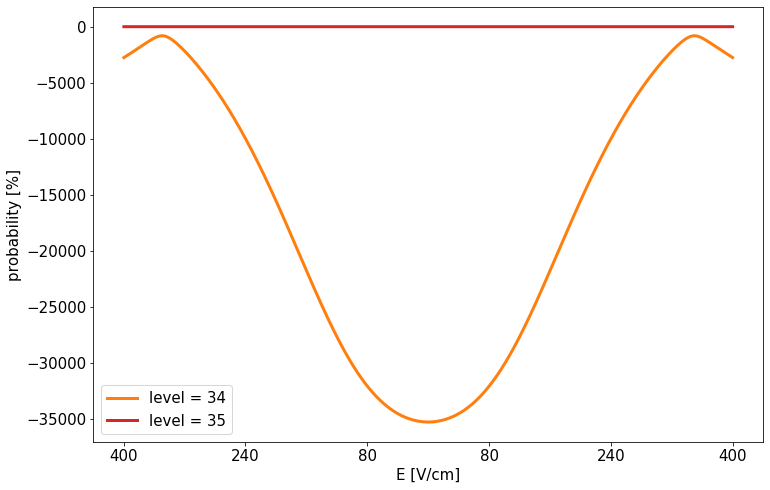

In [621]:
colors = ['C0', 'C1', 'C3', 'C4', 'C5']
idc = 0

idxmax = len(E)
fig, ax = plt.subplots(figsize = (12,8))
for idx in np.unique(np.where(populationsSorted > 0.05)[-1]):
    if idx not in [24,25]:
        ax.plot(energiesSorted[:idxmax,idx]-energiesSorted[:idxmax,35], colors[idc], label = f'level = {idx}', lw = 3)
    idc += 1
pos = np.linspace(0,len(E)-1,6, dtype = int)
ax.set_xticks(pos)
ax.set_xticklabels([f'{Ei:.0f}'for Ei in E[pos]]);
ax.legend(fontsize = 15)
ax.set_xlabel('E [V/cm]')
ax.set_ylabel('energy [%]')
set_fontsize(ax, 15)

## Field change velocity scan
Checking the final state probability as a function of the rate of change of the electric field.  
First simulation for Emax = 1 kV/cm

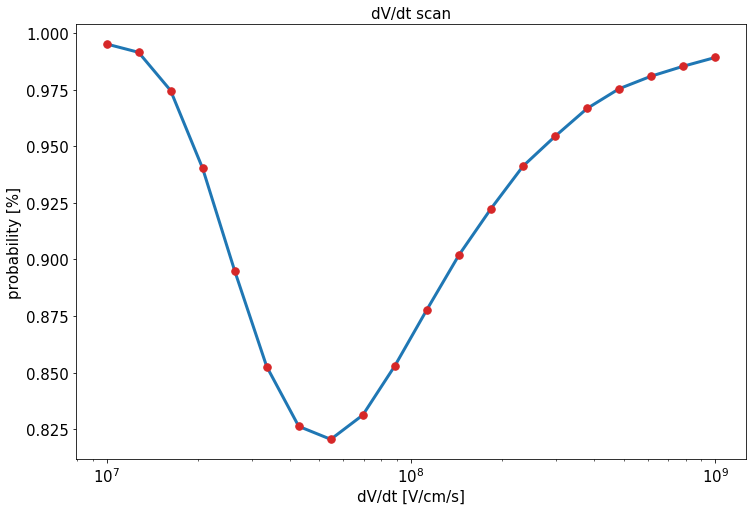

In [622]:
fig, ax = plt.subplots(figsize = (12,8))
ax.set_xlabel('dV/dt [V/cm/s]')
ax.set_ylabel('probability [%]')
ax.set_title('dV/dt scan')
set_fontsize(ax, 15)

probabilities = []
dVdt = np.logspace(7,9,20)

for dV in dVdt:
    t,E,phi,H = propagate_Vfield(hamJ6, 1000, dV, (0,0,0.5), 2500, 35)
    probabilities.append(np.abs(phi[-1].conj()@phi[0]))
    
    ax.cla()
    ax.plot(dVdt[:len(probabilities)], probabilities, lw = 3)
    ax.plot(dVdt[:len(probabilities)], probabilities, '.C3', ms = 15)
    ax.set_xlabel('dV/dt [V/cm/s]')
    ax.set_ylabel('probability [%]')
    ax.set_title('dV/dt scan')
    ax.set_xscale('log')
    set_fontsize(ax, 15)
    display(fig)
    clear_output(wait = True)

In [623]:
t,E,phi,H = propagate_Vfield_tqdm(hamJ6, 1000, 5.5e7, (0,0,0.5), 4000, 35)
energies, populations = calculate_levels_populations(phi, H)

In [624]:
%%time
from order_eigenstates import *
energiesSorted, eigenvectors, order = eigenshuffle(H, return_reorder = True)

Wall time: 11min 13s


In [625]:
populationsSorted = calculate_levels_populations_sorted(phi, eigenvectors)

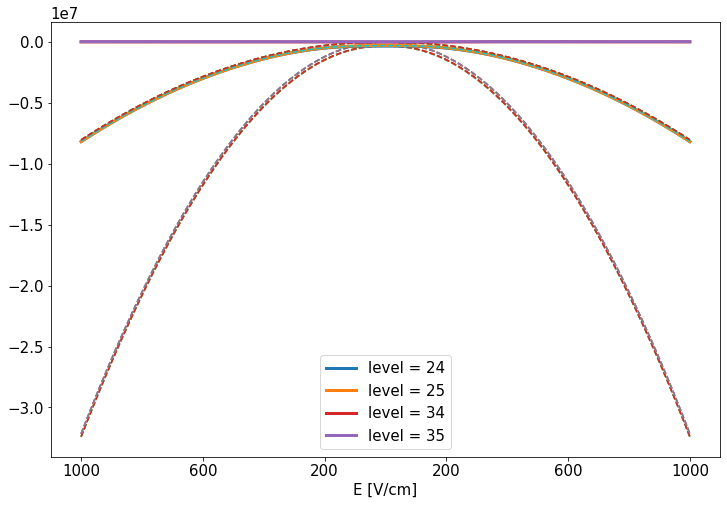

In [626]:
idxmax = len(E)
colors = ['C0', 'C1', 'C3', 'C4', 'C5']
idc = 0
fig, ax = plt.subplots(figsize = (12,8))
for idx in range(16,36):
    if idx in np.unique(np.where(populationsSorted > 0.05)[-1]):
        ax.plot(energiesSorted[:idxmax,idx]-energiesSorted[:idxmax,35], colors[idc], label = f'level = {idx}', lw = 3)
        idc += 1
    else:
        ax.plot(energiesSorted[:idxmax,idx]-energiesSorted[:idxmax,35], '--')
pos = np.linspace(0,len(E)-1,6, dtype = int)
ax.set_xticks(pos)
ax.set_xticklabels([f'{Ei:.0f}'for Ei in E[pos]]);
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.legend(fontsize = 15)
ax.set_xlabel('E [V/cm]')
set_fontsize(ax, 15)

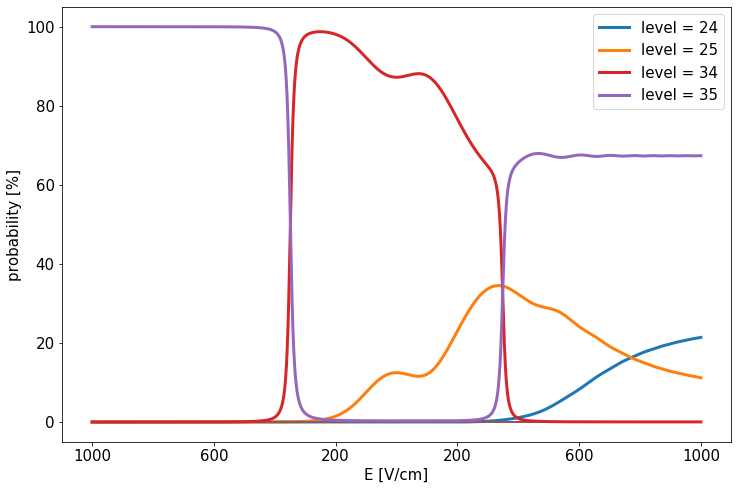

In [627]:
colors = ['C0', 'C1', 'C3', 'C4', 'C5']
idc = 0

fig, ax = plt.subplots(figsize = (12,8))
for idx in range(16,36):
    if idx in np.unique(np.where(populationsSorted > 0.05)[-1]):
        ax.plot(populationsSorted[:idxmax,idx]*100, colors[idc], label = f'level = {idx}', lw = 3)
        idc += 1
    else:
        ax.plot(populationsSorted[:idxmax,idx]*100, '-')

pos = np.linspace(0,len(E)-1,6, dtype = int)
ax.set_xticks(pos)
ax.set_xticklabels([f'{Ei:.0f}'for Ei in E[pos]]);
ax.legend(fontsize = 15)
ax.set_xlabel('E [V/cm]')
ax.set_ylabel('probability [%]')
set_fontsize(ax, 15)

In [628]:
hamJ6.level_eigenstates(0,0,400,0,0,0.5, np.unique(np.where(populationsSorted > 0.05)[-1]), 0.5)

-----------------------
Level = 24
E = +4.0140712706866749e+07 kHz
	-1.000 +0.000i 2 -1 +0.5 +0.5
	-0.628 +0.000i 2 +1 -0.5 -0.5
-----------------------
Level = 25
E = +4.0140720096018754e+07 kHz
	-1.000 +0.000i 2 +1 -0.5 -0.5
	+0.630 +0.000i 2 -1 +0.5 +0.5
-----------------------
Level = 34
E = +4.0142120222957142e+07 kHz
	+1.000 +0.000i 2 +0 -0.5 +0.5
	+0.743 +0.000i 2 +0 +0.5 -0.5
-----------------------
Level = 35
E = +4.0142122976632006e+07 kHz
	+1.000 +0.000i 2 +0 +0.5 -0.5
	-0.745 +0.000i 2 +0 -0.5 +0.5


Besides the original m$_J=0$ state they they end up going to two different states, both being aa superposition of m$J=1$ and m$_J=-1$. First they go from the m$_J=0$ state to another $m_J=0$ state due to the avoided crossing, and then they transfer to another m$_J$ state. After going through the avoided crossing again, transferring back to the original m$_J=0$. Part of the population that transferred to another m$_J$ state now transfers to yet another m$_J$ state, which appears to continue above 1 kV/cm.

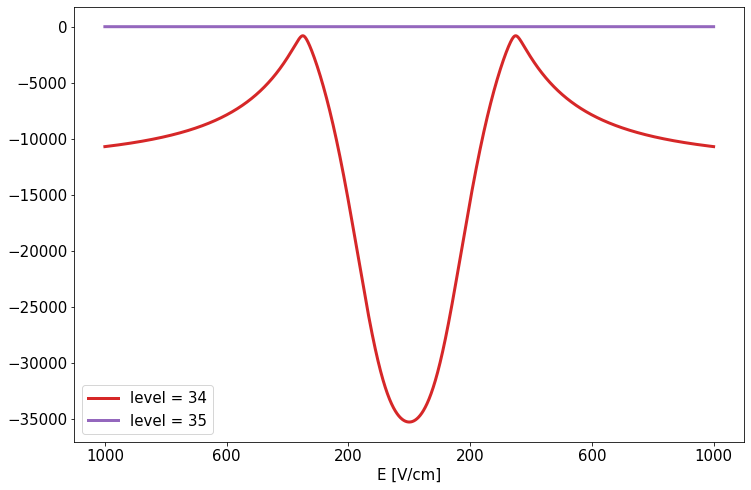

In [629]:
colors = ['C0', 'C1', 'C3', 'C4', 'C5']
idc = 0

idxmax = len(E)
fig, ax = plt.subplots(figsize = (12,8))
for idx in np.unique(np.where(populationsSorted > 0.05)[-1]):
    if idx not in [24,25]:
        ax.plot(energiesSorted[:idxmax,idx]-energiesSorted[:idxmax,35], colors[idc], label = f'level = {idx}', lw = 3)
    idc += 1
pos = np.linspace(0,len(E)-1,6, dtype = int)
ax.set_xticks(pos)
ax.set_xticklabels([f'{Ei:.0f}'for Ei in E[pos]]);
ax.legend(fontsize = 15)
ax.set_xlabel('E [V/cm]')
set_fontsize(ax, 15)

## Field change velocity scan
Checking the final state probability as a function of the rate of change of the electric field.  
First simulation for Emax = 5 kV/cm

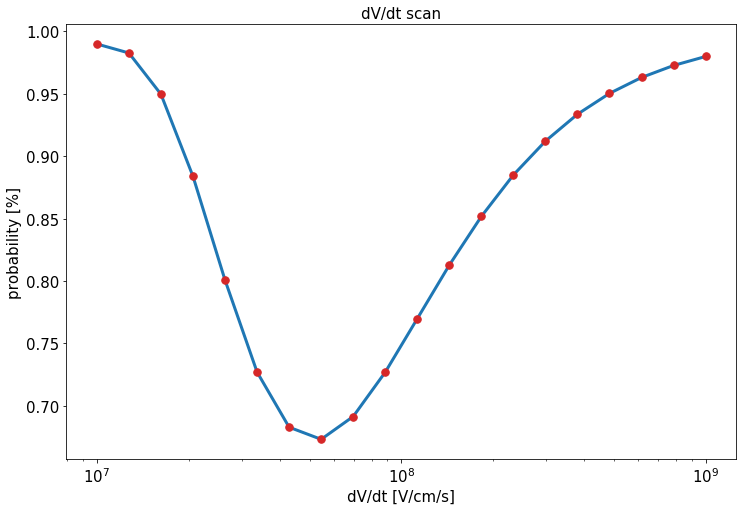

In [630]:
fig, ax = plt.subplots(figsize = (12,8))
ax.set_xlabel('dV/dt [V/cm/s]')
ax.set_ylabel('probability [%]')
ax.set_title('dV/dt scan')
set_fontsize(ax, 15)

probabilities = []
dVdt = np.logspace(7,9,20)

for dV in dVdt:
    t,E,phi,H = propagate_Vfield(hamJ6, 5000, dV, (0,0,0.5), 10000, 35)
    probabilities.append(np.abs(phi[-1].conj()@phi[0])**2)
    
    ax.cla()
    ax.plot(dVdt[:len(probabilities)], probabilities, lw = 3)
    ax.plot(dVdt[:len(probabilities)], probabilities, '.C3', ms = 15)
    ax.set_xlabel('dV/dt [V/cm/s]')
    ax.set_ylabel('probability [%]')
    ax.set_title('dV/dt scan')
    ax.set_xscale('log')
    set_fontsize(ax, 15)
    display(fig)
    clear_output(wait = True)

In [631]:
t,E,phi,H = propagate_Vfield_tqdm(hamJ6, 5000, 5.5e7, (0,0,0.5), 15000, 35)
energies, populations = calculate_levels_populations(phi, H)

In [632]:
%%time
from order_eigenstates import *
energiesSorted, eigenvectors, order = eigenshuffle(H, return_reorder = True)

Wall time: 30min 19s


In [633]:
populationsSorted = calculate_levels_populations_sorted(phi, eigenvectors)

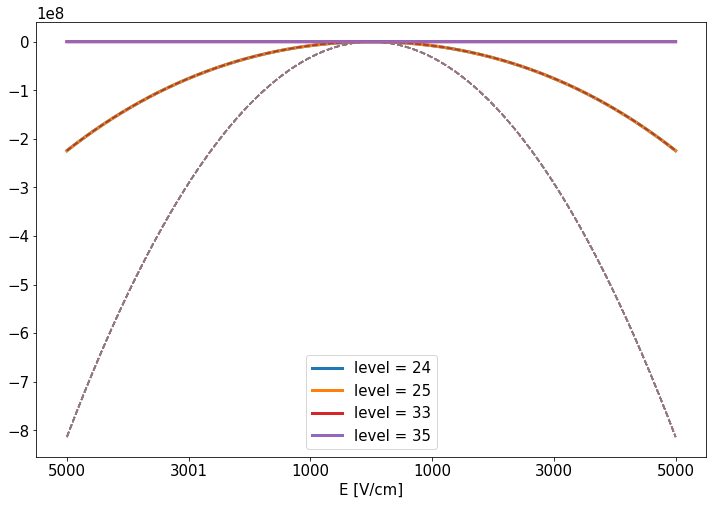

In [634]:
idxmax = len(E)
colors = ['C0', 'C1', 'C3', 'C4', 'C5']
idc = 0
fig, ax = plt.subplots(figsize = (12,8))
for idx in range(16,36):
    if idx in np.unique(np.where(populationsSorted > 0.05)[-1]):
        ax.plot(energiesSorted[:idxmax,idx]-energiesSorted[:idxmax,35], colors[idc], label = f'level = {idx}', lw = 3)
        idc += 1
    else:
        ax.plot(energiesSorted[:idxmax,idx]-energiesSorted[:idxmax,35], '--')
pos = np.linspace(0,len(E)-1,6, dtype = int)
ax.set_xticks(pos)
ax.set_xticklabels([f'{Ei:.0f}'for Ei in E[pos]]);
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.legend(fontsize = 15)
ax.set_xlabel('E [V/cm]')
set_fontsize(ax, 15)

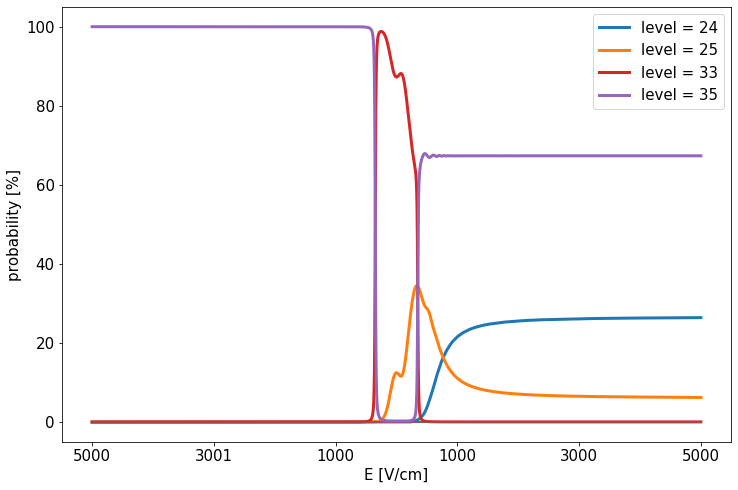

In [636]:
colors = ['C0', 'C1', 'C3', 'C4', 'C5']
idc = 0

fig, ax = plt.subplots(figsize = (12,8))
for idx in range(16,36):
    if idx in np.unique(np.where(populationsSorted > 0.05)[-1]):
        ax.plot(populationsSorted[:idxmax,idx]*100, colors[idc], label = f'level = {idx}', lw = 3)
        idc += 1
    else:
        ax.plot(populationsSorted[:idxmax,idx]*100, '-')

pos = np.linspace(0,len(E)-1,6, dtype = int)
ax.set_xticks(pos)
ax.set_xticklabels([f'{Ei:.0f}'for Ei in E[pos]]);
ax.legend(fontsize = 15)
ax.set_xlabel('E [V/cm]')
ax.set_ylabel('probability [%]')
set_fontsize(ax, 15)

In [13]:
hamJ6.level_eigenstates(0,0,1000,0,0,0.5, [24,25,33,35], 0.5)

-----------------------
Level = 24
E = +4.0147479284565903e+07 kHz
	+1.000 +0.000i 2 -1 +0.5 +0.5
-----------------------
Level = 25
E = +4.0147482789462879e+07 kHz
	-1.000 +0.000i 2 +1 -0.5 -0.5
-----------------------
Level = 33
E = +4.0155661018742524e+07 kHz
	-1.000 +0.000i 2 +0 -0.5 -0.5
-----------------------
Level = 35
E = +4.0155672357874379e+07 kHz
	-1.000 +0.000i 2 +0 +0.5 -0.5
	+0.931 +0.000i 2 +0 -0.5 +0.5


In [2]:
hamJ6.level_eigenstates(0,0,1000,0,0,0.5, np.unique(np.where(populationsSorted > 0.05)[-1]), 0.5)

NameError: name 'hamJ6' is not defined

Besides the original m$_J=0$ state they they end up going to two different states, both being aa superposition of m$J=1$ and m$_J=-1$. First they go from the m$_J=0$ state to another $m_J=0$ state due to the avoided crossing, and then they transfer to another m$_J$ state. After going through the avoided crossing again, transferring back to the original m$_J=0$. Part of the population that transferred to another m$_J$ state now transfers to yet another m$_J$ state, which finally settles to an equilibrium.

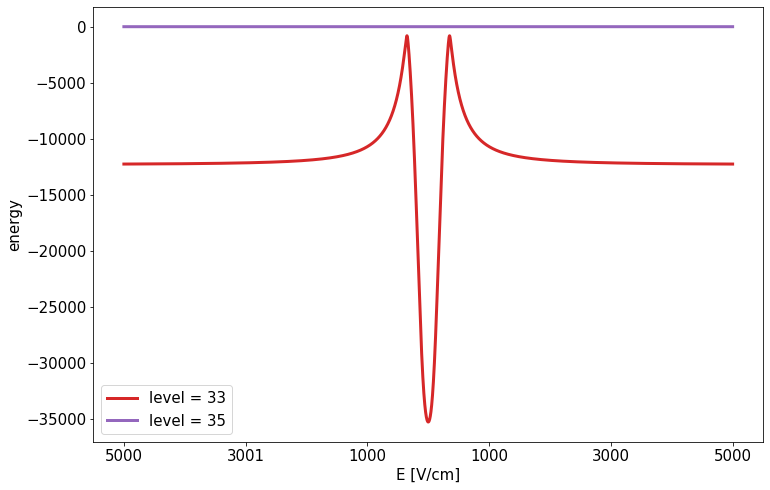

In [638]:
colors = ['C0', 'C1', 'C3', 'C4', 'C5']
idc = 0

idxmax = len(E)
fig, ax = plt.subplots(figsize = (12,8))
for idx in np.unique(np.where(populationsSorted > 0.05)[-1]):
    if idx not in [24,25]:
        ax.plot(energiesSorted[:idxmax,idx]-energiesSorted[:idxmax,35], colors[idc], label = f'level = {idx}', lw = 3)
    idc += 1
pos = np.linspace(0,len(E)-1,6, dtype = int)
ax.set_xticks(pos)
ax.set_xticklabels([f'{Ei:.0f}'for Ei in E[pos]]);
ax.legend(fontsize = 15)
ax.set_xlabel('E [V/cm]')
ax.set_ylabel('energy')
set_fontsize(ax, 15)

In [644]:
del t,E,phi,H,energiesSorted, eigenvectors, order, energies, populations, populationsSorted

## Now include a rotation of the field as happens in the real fields
rotating the field in the yz plane

In [907]:
from scipy import signal

def propagate_Vfield_rotate_tqdm(ham, Emax, dEdt, B, steps, initState):
    t = np.linspace(-1,1,steps)
    E = (signal.sawtooth(t*np.pi, width = 0.5)+1)/2 * Emax
    t = (t+1) * Emax/dEdt
    
    H0 = ham.create_hamiltonian(0,0,E[0], *B)
    eigvals, eigvecs = np.linalg.eigh(H0)
    
    phi0 = eigvecs[:,initState]
    phii = phi0.copy()
    dt = np.diff(t)[0]
    H = np.empty([len(t),*H0.shape], dtype = 'complex')
    phi = np.empty([len(t), *phi0.shape], dtype = 'complex')
    
    dt = np.diff(t)[0]
    for idx, (Eyi,Ezi) in enumerate(tqdm(zip(Ey,Ez), total = len(E))):
        Hi = ham.create_hamiltonian(0,Eyi,Ezi, *B)
        phii = (expm(-1j*Hi*dt)@phii)
        H[idx,:] = Hi
        phi[idx,:] = phii

    return t, Ey, Ez, phi, H

def propagate_Vfield_rotate(ham, Emax, dEdt, B, steps, initState):
    t = np.linspace(-1,1,steps)
    E = (signal.sawtooth(t*np.pi, width = 0.5)+1)/2 * Emax
    t = (t+1) * Emax/dEdt
    Ey, Ez = np.cos(2*np.pi*t/(2*t.max()))*E, np.sin(2*np.pi*t/(2*t.max()))*E
    
    H0 = ham.create_hamiltonian(0,0,E[0], *B)
    eigvals, eigvecs = np.linalg.eigh(H0)
    
    phi0 = eigvecs[:,initState]
    phii = phi0.copy()
    dt = np.diff(t)[0]
    H = np.empty([len(t),*H0.shape], dtype = 'complex')
    phi = np.empty([len(t), *phi0.shape], dtype = 'complex')
    
    dt = np.diff(t)[0]
    for idx, (Eyi,Ezi) in enumerate(zip(Ey,Ez)):
        Hi = ham.create_hamiltonian(0,Eyi,Ezi, *B)
        phii = (expm(-1j*Hi*dt)@phii)
        H[idx,:] = Hi
        phi[idx,:] = phii

    return t, Ey, Ez, phi, H

KeyboardInterrupt: 

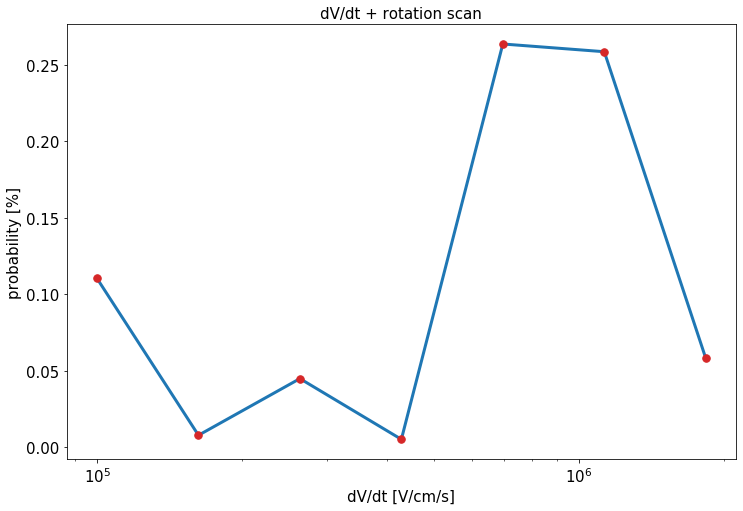

In [918]:
fig, ax = plt.subplots(figsize = (12,8))
ax.set_xlabel('dV/dt [V/cm/s]')
ax.set_ylabel('probability [%]')
ax.set_title('dV/dt scan')
set_fontsize(ax, 15)

probabilities = []
dVdt = np.logspace(5,9,20)

for dV in dVdt:
    t,Ey,Ez,phi,H = propagate_Vfield_rotate(hamJ6, 500, dV, (0,0,0.5), 1200, 35)
    probabilities.append(np.abs(phi[-1].conj()@phi[0])**2)
    
    ax.cla()
    ax.plot(dVdt[:len(probabilities)], probabilities, lw = 3)
    ax.plot(dVdt[:len(probabilities)], probabilities, '.C3', ms = 15)
    ax.set_xlabel('dV/dt [V/cm/s]')
    ax.set_ylabel('probability [%]')
    ax.set_title('dV/dt + rotation scan')
    ax.set_xscale('log')
    set_fontsize(ax, 15)
    display(fig)
    clear_output(wait = True)

# Rotation Scan in Constant Field

In [970]:
def propagate_Cstfield_rotate(ham, Emax, tmax, B, steps, initState):
    t = np.linspace(0,tmax,steps)
    E = np.ones(len(t))*Emax
    Ey, Ez = np.cos(2*np.pi*t/(t.max()))*E, np.sin(2*np.pi*t/(t.max()))*E
    
    H0 = ham.create_hamiltonian(0,0,E[0], *B)
    eigvals, eigvecs = np.linalg.eigh(H0)
    
    phi0 = eigvecs[:,initState]
    phii = phi0.copy()
    dt = np.diff(t)[0]
    H = np.empty([len(t),*H0.shape], dtype = 'complex')
    phi = np.empty([len(t), *phi0.shape], dtype = 'complex')
    
    dt = np.diff(t)[0]
    for idx, (Eyi,Ezi) in enumerate(zip(Ey,Ez)):
        Hi = ham.create_hamiltonian(0,Eyi,Ezi, *B)
        phii = (expm(-1j*Hi*dt)@phii)
        H[idx,:] = Hi
        phi[idx,:] = phii

    return t, Ey, Ez, phi, H

### Using J$_{max} = 6$

Wall time: 16min 26s


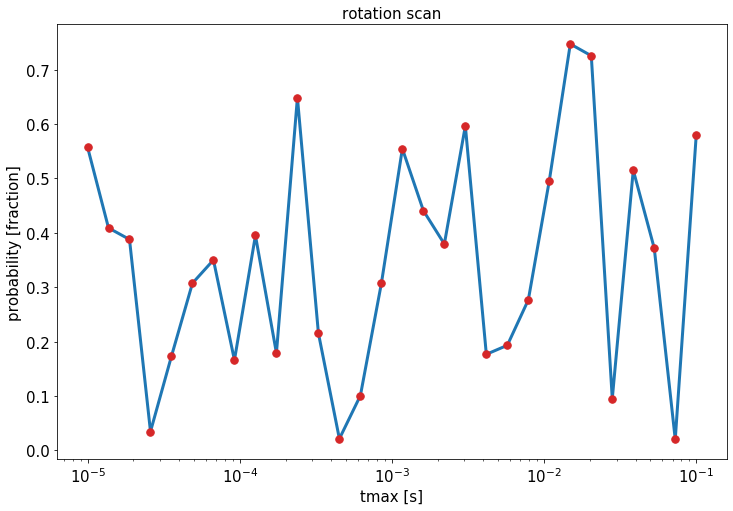

In [979]:
%%time
fig, ax = plt.subplots(figsize = (12,8))
ax.set_xlabel('dV/dt [V/cm/s]')
ax.set_ylabel('probability [fraction]')
ax.set_title('dV/dt scan')
set_fontsize(ax, 15)

probabilities = []
tmaxs = np.logspace(-1,-5,30)

for tmax in tmaxs:
    t,Ey,Ez,phi,H = propagate_Cstfield_rotate(hamJ6, 500, tmax, (0,0,0.5), 1200, 35)
    probabilities.append(np.abs(phi[-1].conj()@phi[0])**2)
    
    ax.cla()
    ax.plot(tmaxs[:len(probabilities)], probabilities, lw = 3)
    ax.plot(tmaxs[:len(probabilities)], probabilities, '.C3', ms = 15)
    ax.set_xlabel('tmax [s]')
    ax.set_ylabel('probability [fraction]')
    ax.set_title('rotation scan')
    ax.set_xscale('log')
    set_fontsize(ax, 15)
    display(fig)
    clear_output(wait = True)

### Using J$_{max}=4$

Wall time: 4min 29s


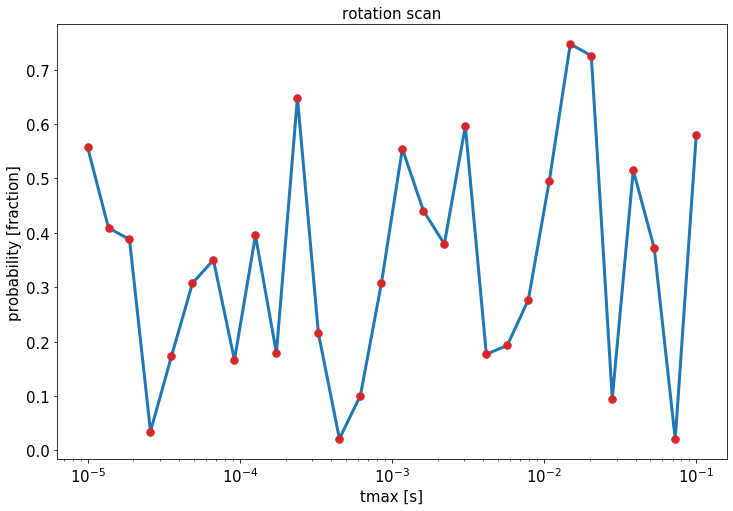

In [980]:
%%time
fig, ax = plt.subplots(figsize = (12,8))
ax.set_xlabel('dV/dt [V/cm/s]')
ax.set_ylabel('probability [fraction]')
ax.set_title('dV/dt scan')
set_fontsize(ax, 15)

probabilities = []
tmaxs = np.logspace(-1,-5,30)

for tmax in tmaxs:
    t,Ey,Ez,phi,H = propagate_Cstfield_rotate(hamJ4, 500, tmax, (0,0,0.5), 1200, 35)
    probabilities.append(np.abs(phi[-1].conj()@phi[0])**2)
    
    ax.cla()
    ax.plot(tmaxs[:len(probabilities)], probabilities, lw = 3)
    ax.plot(tmaxs[:len(probabilities)], probabilities, '.C3', ms = 15)
    ax.set_xlabel('tmax [s]')
    ax.set_ylabel('probability [fraction]')
    ax.set_title('rotation scan')
    ax.set_xscale('log')
    set_fontsize(ax, 15)
    display(fig)
    clear_output(wait = True)

Minimum J$_{max}$ is 4, returning approximately the same results as J$_{max} = 6$. Now do a more thorough scan

In [981]:
import adaptive
import holoviews as hv
adaptive.notebook_extension()

In [982]:
def scan_tmax(tmax):
    t,Ey,Ez,phi,H = propagate_Cstfield_rotate(hamJ4, 500, tmax, (0,0,0.5), 1200, 35)
    return np.abs(phi[-1].conj()@phi[0])**2

In [983]:
learner = adaptive.Learner1D(scan_tmax, bounds=(1e-6, 1))
runner = adaptive.Runner(learner, goal=lambda l: l.loss() < 1e-7)

In [984]:
runner.live_info()

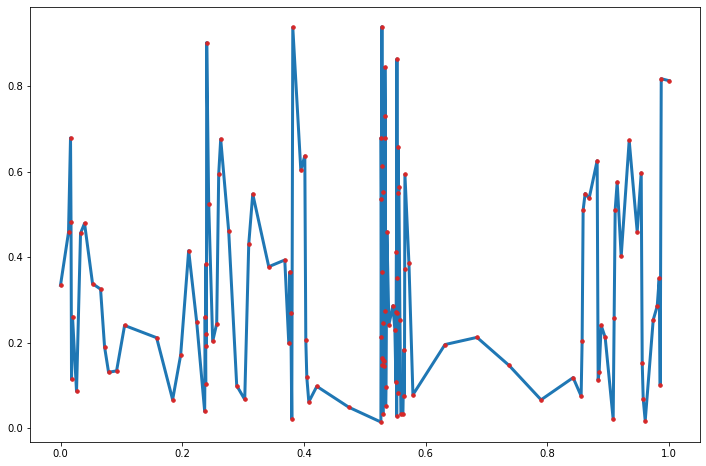

In [997]:
x = np.array(sorted(list(learner.data.keys())))
y = np.array([learner.data[key] for key in x])

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(x,y, lw = 3)
ax.plot(x,y, '.C3', ms = 7)
# ax.set_xscale('log')

# Now checking with real trajectories
Putting the major field in the z direction to simplify the comparison with the toy models.
Shifting the coordinates as follows:  
x -> y  
y -> z  
z -> x  

In [15]:
def funEvec(funEx, funEy, funEz, x,y,z, Emax):
    size = 0
    c = (x,y,z)
    for val in c:
        if isinstance(val, (np.ndarray, list, tuple)):
            size = len(val)
    if size > 0:
        E = np.zeros([size, 3])
        E[:,0] = funEx(*c)
        E[:,1] = funEy(*c)
        E[:,2] = funEz(*c)
    else:
        E = np.zeros([3])
        E[0] = funEx(*c)
        E[1] = funEy(*c)
        E[2] = funEz(*c)
    E[E > Emax] = Emax
    E[E < -Emax] = -Emax
    return E

def funEvec_not_masked(funEx, funEy, funEz,x,y,z):
    size = 0
    c = (x,y,z)
    for val in c:
        if isinstance(val, (np.ndarray, list, tuple)):
            size = len(val)
    if size > 0:
        E = np.zeros([size, 3])
        E[:,0] = funEx(*c)
        E[:,1] = funEy(*c)
        E[:,2] = funEz(*c)
    else:
        E = np.zeros([3])
        E[0] = funEx(*c)
        E[1] = funEy(*c)
        E[2] = funEz(*c)
    return E

In [16]:
from scipy.linalg import expm
from tqdm import tqdm_notebook as tqdm

def propagate_expm_tqdm_zmajor(ham, funEvec, B, t, traj, initState):
    xI,xF,y,z,v = traj
    cI = (xI,y,z)
    eigvals, eigvecs = np.linalg.eigh(ham.create_hamiltonian(*funEvec(*cI), *B))
    
    phi0 = eigvecs[:,initState]
    phi = phi0.copy()
    dt = np.diff(t)[0]
    x = xI
    for ti in tqdm(t):
        phi = (expm(-1j*ham.create_hamiltonian(*funEvec(x,y,z), *B)*dt)@phi)
        x = xI + ti*v

    return phi0, phi

def propagate_expm_save_tqdm_zmajor(ham, funEvec, B, t, traj, initState):
    xI,xF,y,z,v = traj
    cI = (xI,y,z)
    H0 = ham.create_hamiltonian(*funEvec(*cI), *B)
    eigvals, eigvecs = np.linalg.eigh(H0)
    
    phi0 = eigvecs[:,initState]
    phii = phi0.copy()
    dt = np.diff(t)[0]
    x = xI
    H = np.empty([len(t),*H0.shape], dtype = 'complex')
    phi = np.empty([len(t), *phi0.shape], dtype = 'complex')
    for idx, ti in enumerate(tqdm(t)):
        Hi = ham.create_hamiltonian(*funEvec(x,y,z), *B)
        phii = (expm(-1j*Hi*dt)@phii)
        H[idx,:] = Hi
        phi[idx,:] = phii
        x = xI + ti*v

    return phi, H

def propagate_expm_zmajor(ham, funEvec, B, t, traj, initState):
    xI,xF,y,z,v = traj
    cI = (xI,y,z)
    eigvals, eigvecs = np.linalg.eigh(ham.create_hamiltonian(*funEvec(*cI), *B))
    
    phi0 = eigvecs[:,initState]
    phi = phi0.copy()
    dt = np.diff(t)[0]
    x = xI
    for ti in t:
        phi = (expm(-1j*ham.create_hamiltonian(*funEvec(x,y,z), *B)*dt)@phi)
        x = xI + ti*v

    return phi0, phi

In [23]:
def generate_coords_zmajor(traj, dt):
    t = np.arange(0, (traj[1]-traj[0])/traj[-1], dt)
    coords = np.empty([len(t), 3])
    coords[:,0] = traj[0]+traj[-1]*t
    coords[:,1] = traj[2]
    coords[:,2] = traj[3]
    return coords

In [18]:
def calculate_levels_populations_sorted(phi, phiSorted):
    populations = np.empty(phi.shape)
    for idx, (phiI, phiS) in enumerate(tqdm(zip(phi, phiSorted), total = len(phi))):
        for idy, p in enumerate(phiS.T):
            populations[idx,idy] = np.abs(p.conj()@phiI)**2
    return populations

## Setting a straight trajectory in the upper left quadrant of the lens, close to $y=0$

In [20]:
c, intfun = fit_potential_xyz(field_dir+'potentialQuadrupole.fld', 0.022, 0.019, 0, 0)
cP, intfunP = fit_potential_xyz(field_dir+'potentialElectrodes.fld', 0.022, 0.019, .45, 0)
funEx, funEy, funEz ,funEmag = combine_quadrupole_plate(c,intfun,cP,intfunP)
funExConv = lambda x,y,z: funEz(y,z,x)
funEyConv = lambda x,y,z: funEx(y,z,x)
funEzConv = lambda x,y,z: funEy(y,z,x)

traj = (-0.45, 0.45, -0.008, 0.001, 200)
B = (0, 0, 0.5)
dt = 5e-7
t = np.arange(0, (traj[1]-traj[0])/traj[-1], dt)
Ev = lambda x,y,z: funEvec_not_masked(funExConv, funEyConv, funEzConv, x,y,z)

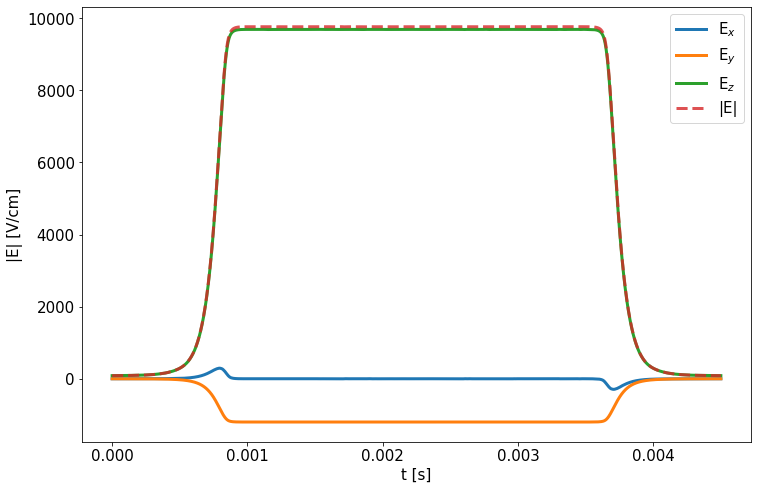

In [16]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(t, Ev(*generate_coords_zmajor(traj, dt).T)[:,0], lw = 3, label = f'E$_x$')
ax.plot(t, Ev(*generate_coords_zmajor(traj, dt).T)[:,1], lw = 3, label = f'E$_y$')
ax.plot(t, Ev(*generate_coords_zmajor(traj, dt).T)[:,2], lw = 3, label = f'E$_z$')
ax.plot(t, np.linalg.norm(Ev(*generate_coords_zmajor(traj, dt).T), axis = 1), '--', lw = 3, label = '|E|', alpha = 0.8)
ax.set_xlabel('t [s]')
ax.set_ylabel('|E| [V/cm]')
ax.legend(fontsize = 15)
set_fontsize(ax, 15)

plot of the fields experienced by this trajectory

In [17]:
phi0, phi = propagate_expm_tqdm_zmajor(hamJ6, Ev, B, t, traj, 35)
print(f'probability = {100*np.abs(phi.conj()@phi0)**2:.2f}%')


probability = 68.53%


### Only put the absolute field in one direction

In [19]:
traj = (-0.45, 0.45, -0.008, 0.001, 200)
B = (0, 0, 0.5)
dt = 5e-7
t = np.arange(0, (traj[1]-traj[0])/traj[-1], dt)

def Ev(x,y,z):
    c = (x,y,z)
    size = 0
    for val in c:
        if isinstance(val, (np.ndarray, list, tuple)):
            size = len(val)
    if size > 0:
        E = np.empty([size,3])
        E[:,0] = np.zeros(size)
        E[:,1] = np.linalg.norm(funEvec_not_masked(funExConv, funEyConv, funEzConv, x,y,z), axis = 1)
        E[:,2] = np.zeros(size)
    else:
        E = np.zeros([3])
        E[0] = 0
        E[1] = np.linalg.norm(funEvec_not_masked(funExConv, funEyConv, funEzConv, x,y,z))
        E[2] = 0
    return E

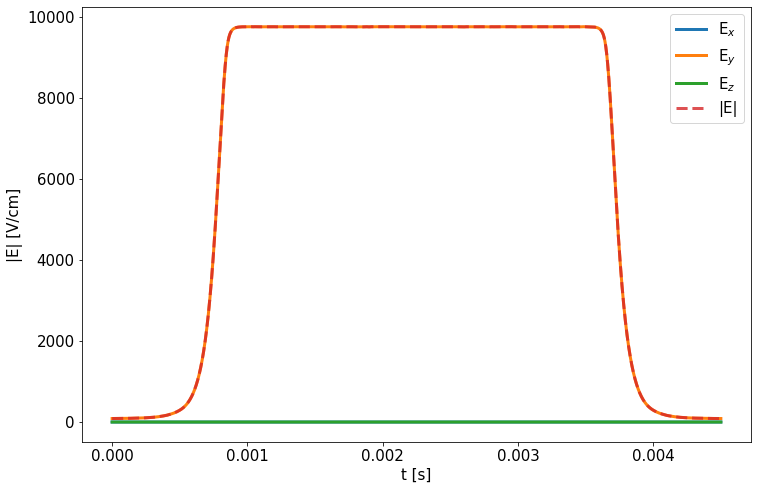

In [852]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(t, Ev(*generate_coords_zmajor(traj, dt).T)[:,0], lw = 3, label = f'E$_x$')
ax.plot(t, Ev(*generate_coords_zmajor(traj, dt).T)[:,1], lw = 3, label = f'E$_y$')
ax.plot(t, Ev(*generate_coords_zmajor(traj, dt).T)[:,2], lw = 3, label = f'E$_z$')
ax.plot(t, np.linalg.norm(Ev(*generate_coords_zmajor(traj, dt).T), axis = 1), '--', lw = 3, label = '|E|', alpha = 0.8)
ax.set_xlabel('t [s]')
ax.set_ylabel('|E| [V/cm]')
ax.legend(fontsize = 15)
set_fontsize(ax, 15)

In [853]:
print(f'maximum field change : {np.diff(Ev(*generate_coords_zmajor(traj, dt).T), axis = 0).max()/dt:.2e} V/cm/s')

maximum field change : 5.92e+07 V/cm/s


In [854]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [880]:
idxmin = find_nearest_idx(Ev(*generate_coords_zmajor(traj, dt).T)[:,1], 100)
idxmax = find_nearest_idx(Ev(*generate_coords_zmajor(traj, dt).T)[:,1], 200)
for idx in range(idxmin,idxmax,50):
    print(f'field change @{Ev(*generate_coords_zmajor(traj, dt).T)[idx,1]} V/cm : {np.diff(Ev(*generate_coords_zmajor(traj, dt).T)[:,1])[idx]/dt:.2e} V/cm/s')

field change @100.0125640885292 V/cm : 1.43e+05 V/cm/s
field change @104.19248591921952 V/cm : 1.88e+05 V/cm/s
field change @109.47858411477132 V/cm : 2.30e+05 V/cm/s
field change @115.35375554447685 V/cm : 2.67e+05 V/cm/s
field change @123.48282089413074 V/cm : 3.85e+05 V/cm/s
field change @134.09457702549446 V/cm : 4.80e+05 V/cm/s
field change @147.17336689651972 V/cm : 5.85e+05 V/cm/s
field change @162.4464616280435 V/cm : 7.32e+05 V/cm/s
field change @184.7073643596168 V/cm : 1.02e+06 V/cm/s


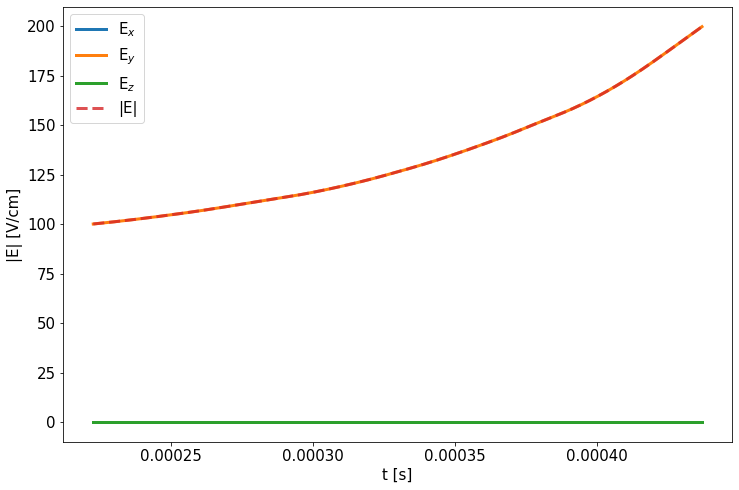

In [849]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(t[idxmin:idxmax], Ev(*generate_coords_zmajor(traj, dt).T)[:,0][idxmin:idxmax], lw = 3, label = f'E$_x$')
ax.plot(t[idxmin:idxmax], Ev(*generate_coords_zmajor(traj, dt).T)[:,1][idxmin:idxmax], lw = 3, label = f'E$_y$')
ax.plot(t[idxmin:idxmax], Ev(*generate_coords_zmajor(traj, dt).T)[:,2][idxmin:idxmax], lw = 3, label = f'E$_z$')
ax.plot(t[idxmin:idxmax], np.linalg.norm(Ev(*generate_coords_zmajor(traj, dt).T), axis = 1)[idxmin:idxmax], '--', lw = 3, label = '|E|', alpha = 0.8)
ax.set_xlabel('t [s]')
ax.set_ylabel('|E| [V/cm]')
ax.legend(fontsize = 15)
set_fontsize(ax, 15)

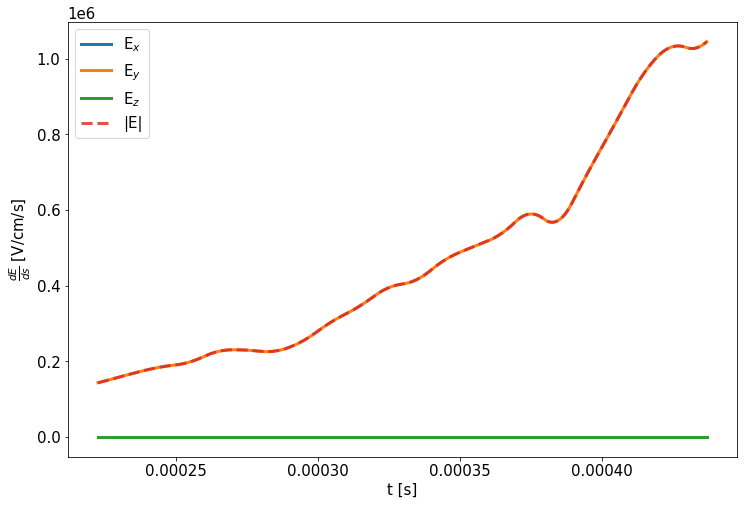

In [889]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(t[idxmin:idxmax], np.diff(Ev(*generate_coords_zmajor(traj, dt).T)[:,0])[idxmin:idxmax]/dt, lw = 3, label = f'E$_x$')
ax.plot(t[idxmin:idxmax], np.diff(Ev(*generate_coords_zmajor(traj, dt).T)[:,1])[idxmin:idxmax]/dt, lw = 3, label = f'E$_y$')
ax.plot(t[idxmin:idxmax], np.diff(Ev(*generate_coords_zmajor(traj, dt).T)[:,2])[idxmin:idxmax]/dt, lw = 3, label = f'E$_z$')
ax.plot(t[idxmin:idxmax], np.diff(np.linalg.norm(Ev(*generate_coords_zmajor(traj, dt).T), axis = 1))[idxmin:idxmax]/dt, 
        '--', lw = 3, label = '|E|', alpha = 0.8)
ax.set_xlabel('t [s]')
ax.set_ylabel(r'$\frac{dE}{ds}$ [V/cm/s]')
ax.legend(fontsize = 15)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
set_fontsize(ax, 15)

In [826]:
phi0, phi = propagate_expm_tqdm_zmajor(hamJ6, Ev, B, t, traj, 35)
print(f'probability = {100*np.abs(phi.conj()@phi0)**2:.2f}%')

probability = 99.64%


So no rotation of fields does not cause any significant movement of populations across states

### Save the state at every timepoint to sort and get a sense of where the states evolve to

In [21]:
traj = (-0.45, 0.45, -0.008, 0.001, 200)
B = (0, 0, 0.5)
dt = 3e-7
t = np.arange(0, (traj[1]-traj[0])/traj[-1], dt)
Ev = lambda x,y,z: funEvec_not_masked(funExConv, funEyConv, funEzConv, x,y,z)

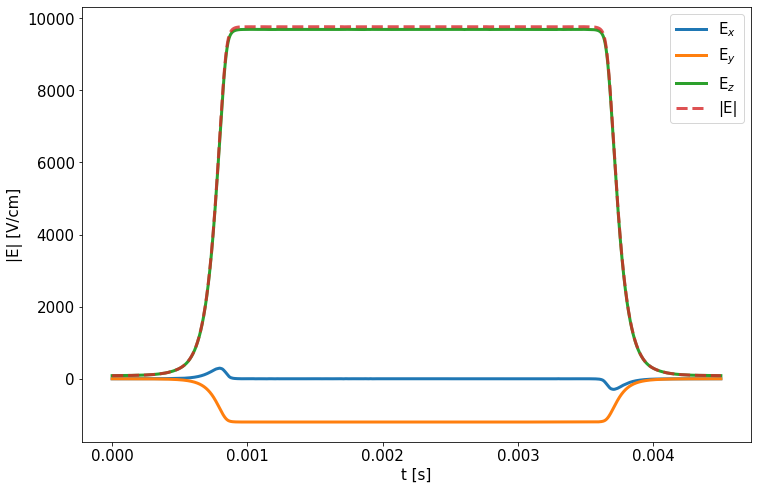

In [23]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(t, Ev(*generate_coords_zmajor(traj, dt).T)[:,0], lw = 3, label = f'E$_x$')
ax.plot(t, Ev(*generate_coords_zmajor(traj, dt).T)[:,1], lw = 3, label = f'E$_y$')
ax.plot(t, Ev(*generate_coords_zmajor(traj, dt).T)[:,2], lw = 3, label = f'E$_z$')
ax.plot(t, np.linalg.norm(Ev(*generate_coords_zmajor(traj, dt).T), axis = 1), '--', lw = 3, label = '|E|', alpha = 0.8)
ax.set_xlabel('t [s]')
ax.set_ylabel('|E| [V/cm]')
ax.legend(fontsize = 15)
set_fontsize(ax, 15)

In [24]:
phi, H = propagate_expm_save_tqdm_zmajor(hamJ6, Ev, B, t, traj, 35)

In [25]:
%%time
from order_eigenstates import *
energiesSorted, eigenvectors, order = eigenshuffle(H, return_reorder = True)

Wall time: 1h 17min 26s


In [28]:
populationsSorted = calculate_levels_populations_sorted(phi, eigenvectors)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


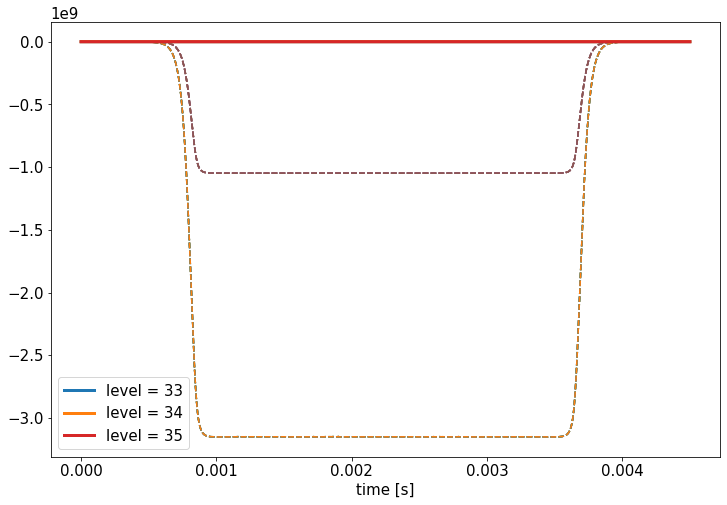

In [29]:
idxmax = len(phi)
colors = ['C0', 'C1', 'C3', 'C4', 'C5']
idc = 0
fig, ax = plt.subplots(figsize = (12,8))
for idx in range(16,36):
    if idx in np.unique(np.where(populationsSorted > 0.05)[-1]):
        ax.plot(t, energiesSorted[:idxmax,idx]-energiesSorted[:idxmax,35], colors[idc], label = f'level = {idx}', lw = 3)
        idc += 1
    else:
        ax.plot(t, energiesSorted[:idxmax,idx]-energiesSorted[:idxmax,35], '--')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.legend(fontsize = 15)
ax.set_xlabel('time [s]')
set_fontsize(ax, 15)

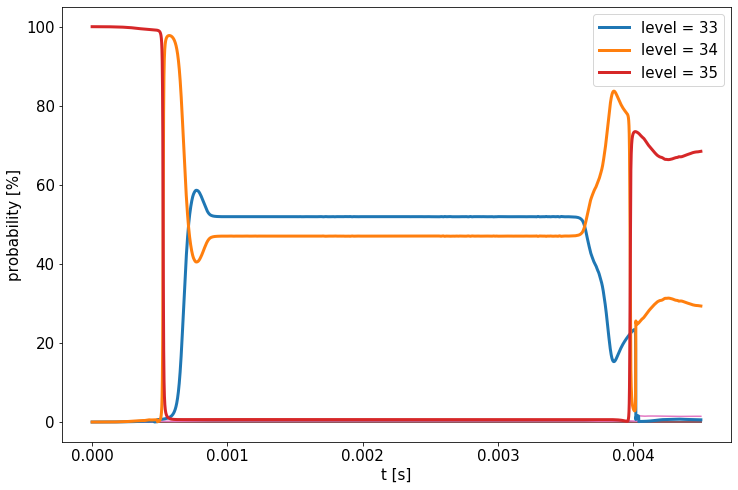

In [30]:
colors = ['C0', 'C1', 'C3', 'C4', 'C5']
idc = 0

fig, ax = plt.subplots(figsize = (12,8))
for idx in range(16,36):
    if idx in np.unique(np.where(populationsSorted > 0.05)[-1]):
        ax.plot(t, populationsSorted[:idxmax,idx]*100, colors[idc], label = f'level = {idx}', lw = 3)
        idc += 1
    else:
        ax.plot(t, populationsSorted[:idxmax,idx]*100, '-')

ax.legend(fontsize = 15)
ax.set_xlabel('t [s]')
ax.set_ylabel('probability [%]')
set_fontsize(ax, 15)

In [ ]:
hamJ6.level_eigenstates(*Ev(*generate_coords(traj, dt).T)[-1,:],0,0.5,0, np.unique(np.where(populationsSorted > 0.001)[-1]), 0.5)

In [31]:
for idx in np.unique(np.where(populationsSorted > 0.001)[-1]):
    print(f'level {idx} : population {100*populationsSorted[-1,idx]:.2f}')

level 14 : population 0.10
level 32 : population 1.45
level 33 : population 0.56
level 34 : population 29.35
level 35 : population 68.47


In [26]:
hamJ6.level_eigenstates(*Ev(*generate_coords(traj, dt).T)[-1,:],0,0.5,0, [33,34,35], 0.5)

-----------------------
Level = 33
E = +4.0195786327360131e+07 kHz
	+1.000 +0.000i 2 +0 -0.5 -0.5
	+0.985 +0.000i 2 +0 +0.5 +0.5
-----------------------
Level = 34
E = +4.0195789039308362e+07 kHz
	+0.053 +0.999i 2 +0 -0.5 +0.5
	+0.053 +0.998i 2 +0 +0.5 -0.5
	-0.607 +0.000i 2 +0 +0.5 +0.5
	+0.598 +0.000i 2 +0 -0.5 -0.5
-----------------------
Level = 35
E = +4.0195799908769667e+07 kHz
	-0.000 +1.000i 2 +0 +0.5 -0.5
	+0.000 -1.000i 2 +0 -0.5 +0.5


In [25]:
hamJ6.level_eigenstates(*Ev(*generate_coords(traj, dt).T)[-1,:],0,0.5,0, np.unique(np.where(populationsSorted > 0.001)[-1]), 0.5)

NameError: name 'populationsSorted' is not defined

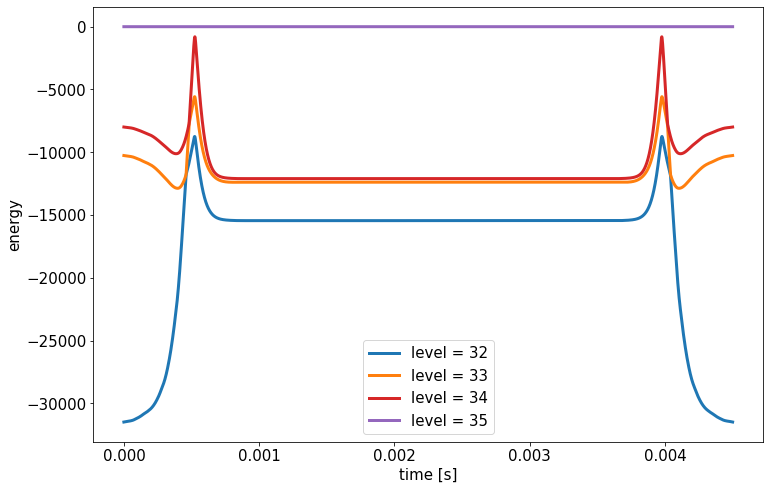

In [33]:
colors = ['C0', 'C1', 'C3', 'C4', 'C5']
idc = 0

idxmax = len(phi)
fig, ax = plt.subplots(figsize = (12,8))
for idx in np.unique(np.where(populationsSorted > 0.01)[-1]):
    if idx not in [24,25]:
        ax.plot(t, energiesSorted[:idxmax,idx]-energiesSorted[:idxmax,35], colors[idc], label = f'level = {idx}', lw = 3)
    idc += 1
ax.legend(fontsize = 15)
ax.set_xlabel('time [s]')
ax.set_ylabel('energy')
set_fontsize(ax, 15)

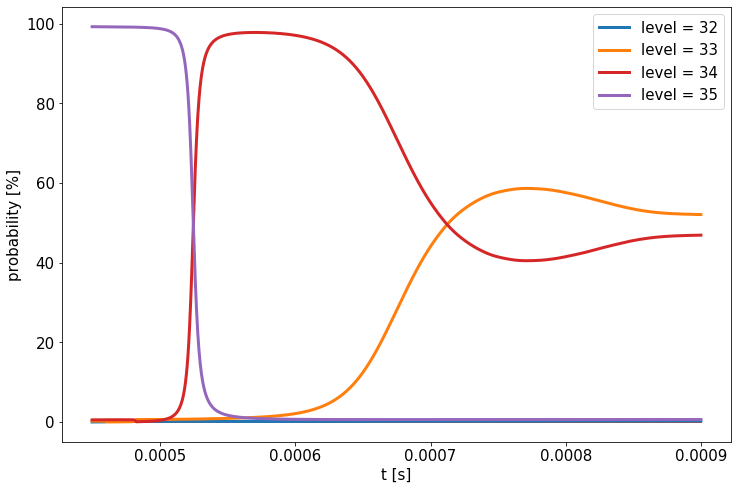

In [34]:
idxmin, idxmax = 1500, 3000
colors = ['C0', 'C1', 'C3', 'C4', 'C5']
idc = 0

fig, ax = plt.subplots(figsize = (12,8))
for idx in range(16,36):
    if idx in np.unique(np.where(populationsSorted > 0.01)[-1]):
        ax.plot(t[idxmin:idxmax], populationsSorted[idxmin:idxmax,idx]*100, colors[idc], label = f'level = {idx}', lw = 3)
        idc += 1
    else:
        ax.plot(t[idxmin:idxmax], populationsSorted[idxmin:idxmax,idx]*100, '-')

ax.legend(fontsize = 15)
ax.set_xlabel('t [s]')
ax.set_ylabel('probability [%]')
set_fontsize(ax, 15)

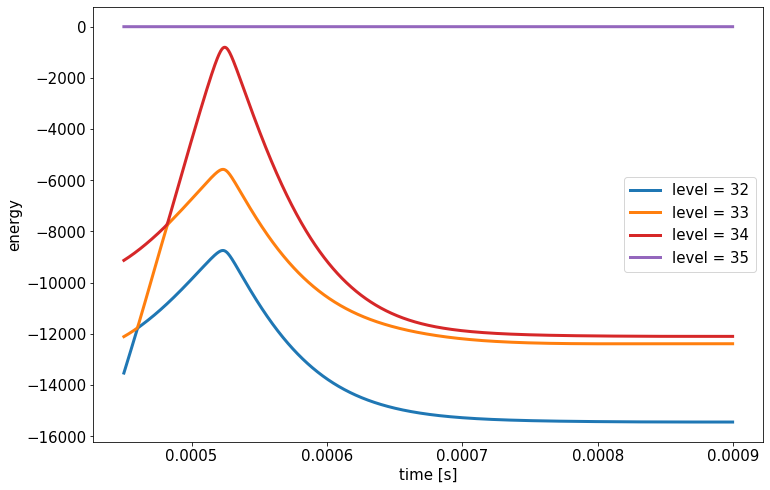

In [35]:
colors = ['C0', 'C1', 'C3', 'C4', 'C5']
idc = 0

fig, ax = plt.subplots(figsize = (12,8))
for idx in np.unique(np.where(populationsSorted > 0.01)[-1]):
    if idx not in [24,25]:
        ax.plot(t[idxmin:idxmax], energiesSorted[idxmin:idxmax,idx]-energiesSorted[idxmin:idxmax,35], colors[idc], label = f'level = {idx}', lw = 3)
    idc += 1
ax.legend(fontsize = 15)
ax.set_xlabel('time [s]')
ax.set_ylabel('energy')
set_fontsize(ax, 15)

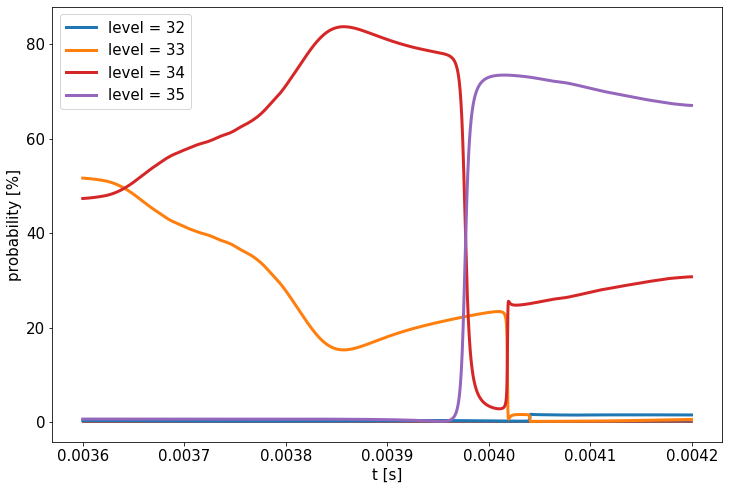

In [36]:
idxmin, idxmax = 12000, 14000
colors = ['C0', 'C1', 'C3', 'C4', 'C5']
idc = 0

fig, ax = plt.subplots(figsize = (12,8))
for idx in range(16,36):
    if idx in np.unique(np.where(populationsSorted > 0.01)[-1]):
        ax.plot(t[idxmin:idxmax], populationsSorted[idxmin:idxmax,idx]*100, colors[idc], label = f'level = {idx}', lw = 3)
        idc += 1
    else:
        ax.plot(t[idxmin:idxmax], populationsSorted[idxmin:idxmax,idx]*100, '-')

ax.legend(fontsize = 15)
ax.set_xlabel('t [s]')
ax.set_ylabel('probability [%]')
set_fontsize(ax, 15)

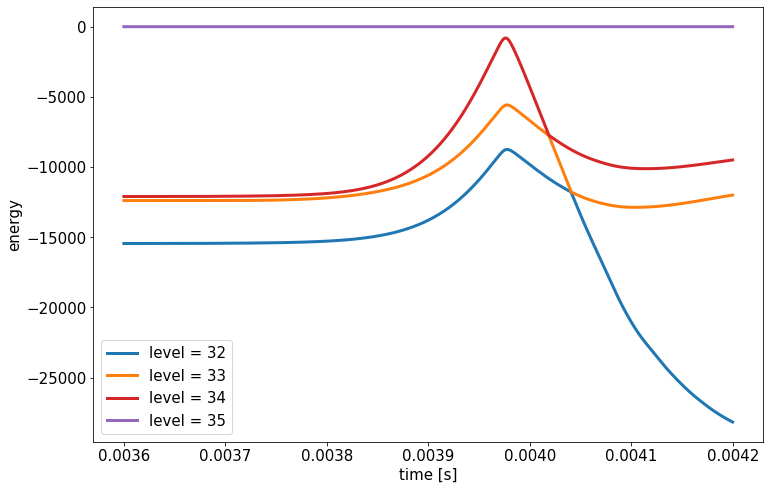

In [37]:
colors = ['C0', 'C1', 'C3', 'C4', 'C5']
idc = 0

fig, ax = plt.subplots(figsize = (12,8))
for idx in np.unique(np.where(populationsSorted > 0.01)[-1]):
    if idx not in [24,25]:
        ax.plot(t[idxmin:idxmax], energiesSorted[idxmin:idxmax,idx]-energiesSorted[idxmin:idxmax,35], colors[idc], label = f'level = {idx}', lw = 3)
    idc += 1
ax.legend(fontsize = 15)
ax.set_xlabel('time [s]')
ax.set_ylabel('energy')
set_fontsize(ax, 15)